In [1209]:
# SimpleFieldGen_Coax
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Potential solver for a coaxial HPGe detector via SOR method
#  - Disclaimer: for demonstration/example purposes only!
#
#  - 2D, radial symmetry around core
#  - does not handle depletion intelligently
#  - does not handle multiple dielectrics
#  - not really handling impurity concentration properly (depletion voltages are too large)
#                    - may be related to the E/E0 interface at the core
#                    - fix it if you like!
#

In [1210]:
%matplotlib inline
%reset -f

In [1211]:
import numpy as np
from matplotlib import pyplot as plt

In [1212]:
# set some detector parameters
detector_length_mm = 90.0
detector_radius_mm = 40.0
pixel_size_mm = 1.0

core_length_mm = 60.0
core_radius_mm = 5.0

wrap_around_mm = 10.0

outer_contact_bias = 3000.0
core_contact_bias = 0.0

charge_density_zero = -1.0
charge_density_gradient = 0.1

In [1213]:
# build (uniform) 2D grids for plotting and solving (x=radius, y=length)
x_range = np.arange(0, detector_radius_mm + pixel_size_mm, pixel_size_mm)
y_range = np.arange(0, detector_length_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

# XY mesh for plotting later
X, Y = np.meshgrid(y_range, x_range)

In [1214]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 outer contact = 1 core = 2 passivated face = 3
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# outer contact
geom_map[(N_xelements-1),:] = 1
geom_map[:,(N_yelements-1)] = 1

# outer contact wrap around
ix = np.where(x_range>=(detector_radius_mm-wrap_around_mm))
geom_map[ix,0] = 1

# control the passivated back face if you like (not tested)
#ix = np.where((x_range>core_radius_mm) & (x_range<(detector_radius_mm-wrap_around_mm)))
#geom_map[ix,0] = 3

In [1215]:
# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = charge_density_zero + charge_density_gradient*(y/pixels_to_cm)

        # core
        if (x_range[x]<core_radius_mm and y_range[y]<core_length_mm):
            charge[x,y] = 0.0
            geom_map[x,y] = 2


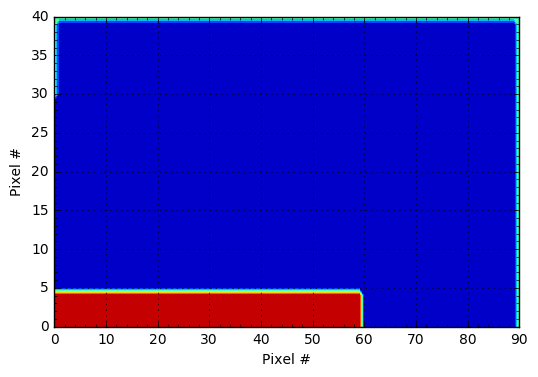

In [1216]:
# view the geometry (x/y are flipped)
plt.contourf(geom_map)
ax = plt.axes()
plt.minorticks_on()
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.show()

In [1217]:
# set boundary conditions and generate initial guess at solution

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = outer_contact_bias*x / N_xelements

# outer contact
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# core
x,y = np.where(geom_map==2)
V[x,y] = core_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

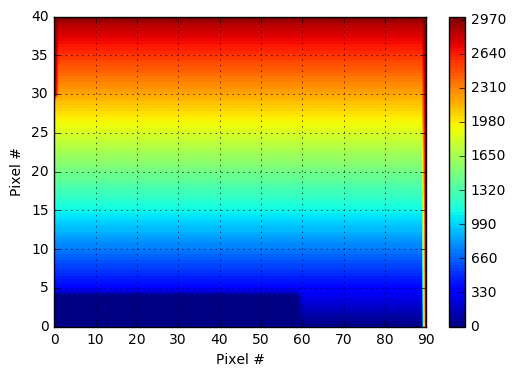

In [1218]:
# inspect initial conditions for V (x/y are flipped)
plt.contourf(V,100,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()

In [1219]:
# do the relaxation to solve

# set maximum number of iterations
max_iters = 1000

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(0, N_yelements):
        for x in range(0, N_xelements):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
                
            # deal with reflection symmetry at x=0
            if (x == 0):
                V_local_sum = (V[x,y-1] + V[x,y+1] + 2.0*V[x+1,y])

            elif (y == 0):
                V_local_sum = (V[x-1,y] + V[x+1,y] + 2.0*V[x,y+1])

            # all other cases
            else:                                
                V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1


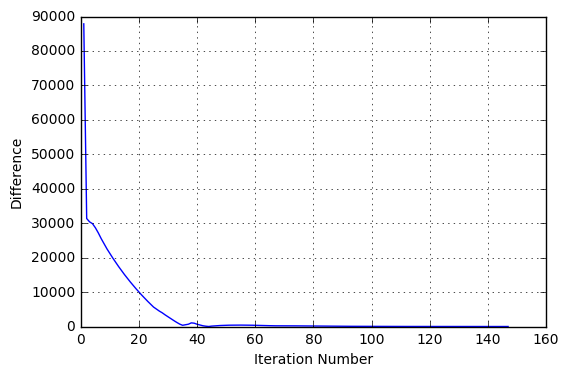

Final Difference:
0.00871243659753


In [1220]:
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])


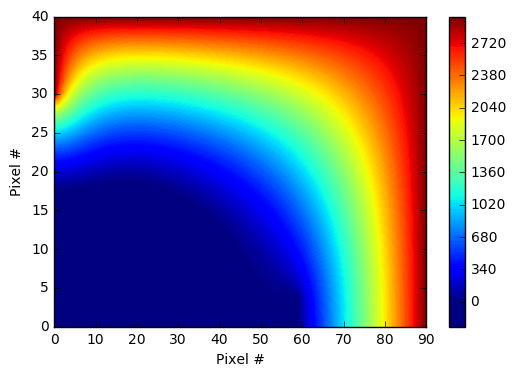

In [1221]:
plt.contourf(V, 200, vmin=0)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()

In [1222]:
# apply mirror symmetry around x = 0 to create a full potential map for visualization
Vfinal = np.flipud(V)
Vfinal = np.append(Vfinal, V, axis=0)

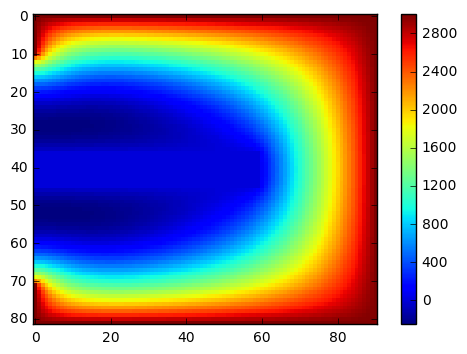

In [1223]:
# plot the computed potential
plt.imshow(Vfinal, interpolation="None", cmap="jet")
plt.colorbar()

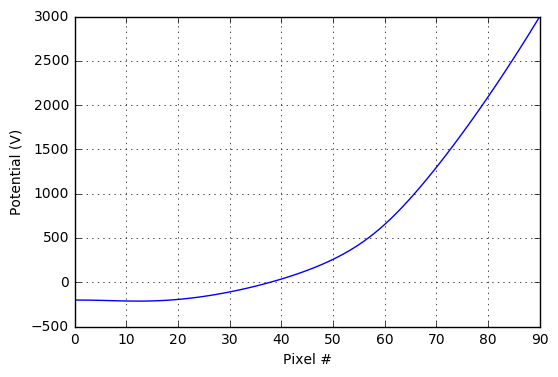

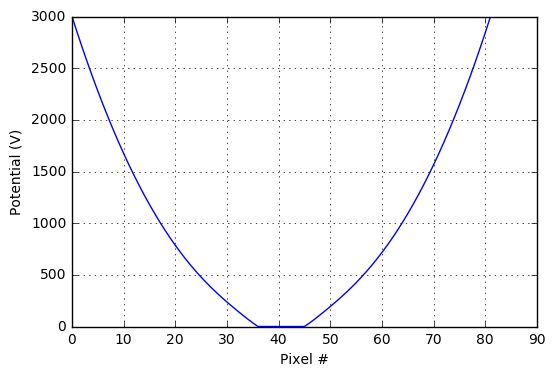

In [1224]:
# plot some potential/field slices
yy = 55
xx = 10

# V along the longitudinal direction at rad = yy
plt.plot(Vfinal[yy,:])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

# V along the radial direction at long = xx
plt.plot(Vfinal[:,yy])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

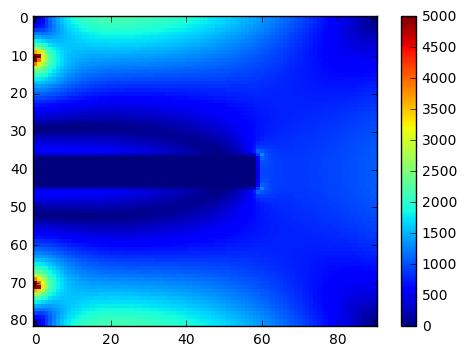

In [1225]:
# calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))

Efinal = np.flipud(E)
Efinal = np.append(Efinal, E, axis=0)

plt.imshow(Efinal, vmax=5000, interpolation="None", cmap="jet")
plt.colorbar()

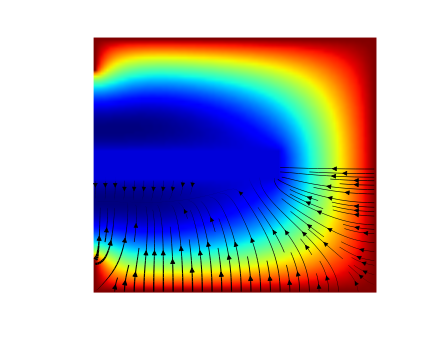

In [1226]:
# plot the potential and overlay field lines
lw = 3 * E/E.max()
plt.imshow(Vfinal)
plt.streamplot(X, detector_radius_mm+pixel_size_mm+Y, Ey, Ex, color='k', linewidth=lw)
plt.axis("off")
plt.show()